In [49]:
#Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from scipy.stats import shapiro

In [4]:
#Read csv file , ab_data is from Kaggle https://www.kaggle.com/zhangluyuan/ab-testing
raw_df = pd.read_csv('ab_data.csv')
raw_df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# Data Exploratory

In [5]:
#check if there is missing data
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
#check if user_id is unique for each row of data
print("Unique user_id count: {0:,} \
      \nTotal row count: {1:,}"\
      .format(raw_df.user_id.nunique(), raw_df.user_id.count()))

Unique user_id count: 290,584       
Total row count: 294,478


In [7]:
#check if control and variation is split evenly
summary_df = pd.DataFrame(raw_df.groupby('group')['user_id'].nunique()).reset_index()
summary_df.rename(columns={'user_id':'unique_user_ct'}, inplace=True)
summary_df['group_pct'] = summary_df['unique_user_ct'] / summary_df['unique_user_ct'].sum()
summary_df

,group,unique_user_ct,group_pct
0,control,146195,0.499848
1,treatment,146284,0.500152


In [8]:
#check if user_id in both groups
check_df = pd.DataFrame(raw_df.groupby('user_id')['group'].nunique()).reset_index()
check_df = check_df[check_df['group'] ==2]
check_df.count()

user_id    1895
group      1895
dtype: int64

In [9]:
#remove userids in both groups
df = raw_df[~raw_df['user_id'].isin(check_df['user_id'])] #~ is for not
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290688 non-null int64
timestamp       290688 non-null object
group           290688 non-null object
landing_page    290688 non-null object
converted       290688 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


C:\Users\Helen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


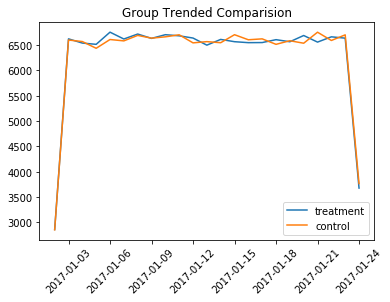

In [10]:
#check if group is consistent by dates
df['date'] = [d.date() for d in pd.to_datetime(df['timestamp'])]
date_df = pd.DataFrame(df.groupby(['date', 'group'])['user_id'].count()).reset_index()
plt.plot(date_df[date_df['group'] == 'treatment'].date, date_df[date_df['group'] == 'treatment'].user_id, label = 'treatment')
plt.plot(date_df[date_df['group'] == 'control'].date, date_df[date_df['group'] == 'control'].user_id, label = 'control')

plt.legend(loc='best')
# tilt the x axis
plt.xticks(rotation=45)
plt.title('Group Trended Comparision')
plt.show()

In [12]:
#look at the group comparison by table
date_pivot_df = date_df.pivot(values='user_id', index ='date', columns='group')
date_pivot_df.head()

group,control,treatment
date,,
2017-01-02,2854,2861
2017-01-03,6596,6619
2017-01-04,6566,6536
2017-01-05,6433,6511
2017-01-06,6606,6751


In [19]:
df['converted'].unique()

array([0, 1], dtype=int64)

#  Selecting A/B Test

In [42]:
#Is the metric proportional or means
#We want to use conversion rate by day as the metric so proportional variable
#Aggregate the table by dates
int_df = pd.DataFrame(df.groupby(['date', 'group'])['user_id'].nunique()).reset_index()
int2_df = pd.DataFrame(df.groupby(['date', 'group'])['converted'].sum()).reset_index()
base_df = pd.merge(int_df, int2_df, on=['date','group'])
base_df['conv_rate'] = base_df['converted'] / base_df['user_id']
base_df.head()

,date,group,user_id,converted,conv_rate
0,2017-01-02,control,2854,359,0.125788
1,2017-01-02,treatment,2861,345,0.120587
2,2017-01-03,control,6594,748,0.113436
3,2017-01-03,treatment,6619,754,0.113914
4,2017-01-04,control,6564,799,0.121725


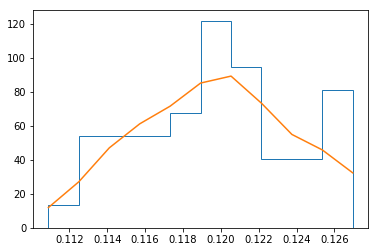

In [51]:
#Is the metric parametric or nonparametric?
#https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
#check via histogram
density = stats.gaussian_kde(base_df['conv_rate'])
n, x, _ = plt.hist(base_df['conv_rate'] , 
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.show()

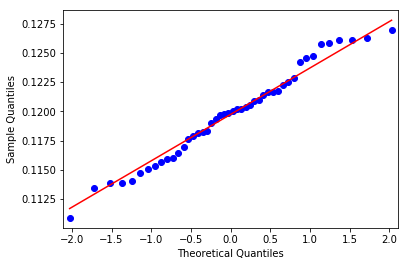

In [46]:
#check via Q-Q plot
qqplot(base_df['conv_rate'], line='s')
plt.show()

In [48]:
#check via Shapiro-Wilk Test
stat, p = shapiro(base_df['conv_rate'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.975, p=0.407
Sample looks Gaussian (fail to reject H0)


In [52]:
#check if it is normal or t distribution
#sample size is less than 30 then t
#AND unknown population variance then t (we usually don't know population variance)

print('Sample size: {}'.format(base_df['date'].count()))

Sample size: 46


In [ ]:
#Is data paired or unpaired
#Most likely it is unpaired because paired looks like pre vs post of the same sample

In [ ]:
#Test one-tail or two-tail
# if the test is can't rejecct the null hypothesis or is negative is no difference then one-tail


In [ ]:
#Is it two sample or one?